## CMSC 35300 Final Project: Least Squares Models
Shweta Kamath <br>
Nivedita Vatsa <br>
Carolyn Vilter

#### Setup

In [688]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [689]:
# Import combined, cleaned, standardized data
df = pd.read_csv("data/all_data_standardized.csv")

In [690]:
df

,child_id,mother_id,treat_alike_scale,treat_alike_binary,year_at_y,gap_at_y,self_worth,yob_child,father_present,religion_freq,...,highest_expected_grade_GET MORE THAN 4 YEARS OF COLLEGE,highest_expected_grade_SOMETHING ELSE,mother_race_BLACK,"mother_race_NON-BLACK, NON-HISPANIC",mother_relig_raised_protestant,mother_relig_raised_catholic,mother_relig_raised_other,mother_relig_current_protestant,mother_relig_current_catholic,mother_relig_current_other
0,301,3,2,1,0.0,0.5,0.555556,0.045455,1.000000,0.2,...,0,0,0,1,0,1,0,0,1,0
1,302,3,1,1,0.1,0.5,1.000000,0.136364,1.000000,0.5,...,0,0,0,1,0,1,0,0,1,0
2,303,3,1,1,0.3,1.0,0.888889,0.272727,1.000000,0.8,...,0,0,0,1,0,1,0,0,0,1
3,803,8,1,1,0.1,1.0,0.611111,0.090909,0.363636,0.2,...,0,0,0,1,0,0,1,1,0,0
4,1601,16,1,1,0.5,1.0,0.666667,0.454545,1.000000,0.6,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,1255801,12558,2,1,0.4,0.5,1.000000,0.409091,0.000000,1.0,...,0,0,1,0,0,0,1,0,0,1
5157,1256602,12566,2,1,0.2,0.5,0.888889,0.227273,1.000000,1.0,...,0,0,1,0,1,0,0,1,0,0
5158,1256603,12566,1,1,0.4,1.0,0.888889,0.363636,0.888889,1.0,...,1,0,1,0,1,0,0,1,0,0
5159,1256604,12566,1,1,0.5,0.0,0.944444,0.545455,0.714286,1.0,...,1,0,1,0,1,0,0,1,0,0


In [691]:
# Separate out Xs
X = df.loc[:, ~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"])]
X = X.to_numpy()

# Separate out two prospective ys
y_scale = df.loc[:, df.columns == "treat_alike_scale"]
y_scale = y_scale.to_numpy()

y_binary = df.loc[:, df.columns == "treat_alike_binary"]
y_binary = y_binary.to_numpy()

In [692]:
X.shape

(5161, 43)

### Least Squares
Predict repeatedly using cross validation; plot test error.

In [693]:
def perform_ls(N, y):
    '''
    Performs least squares with cross validation over N iterations using the indicated
    y variable (of the two choices "y_binary" and "y_scale"). 
    
    Prints three plots:
        "Distribution of Predicted Labels Over N Iterations"
        "Distribution of True Labels"
        "Distribution of Test Error Over N Iterations"
    And returns two pieces of information:
        Average error rate over all iterations
        Best w-hat from all iterations (w-hat associated with the lowest error)
    '''

    # Store error values
    errs = np.zeros(N)
    min_err = 1
    # Store best w-hat (associated with lowest error)
    best_w_hat = None
    # Number of observations/samples
    n = X.shape[0]
    # Chosen number of sets to divide dataset into
    n_sets = 10
    # Final index of the training set (9 of 10 subsets)
    t_index = n//n_sets*(n_sets-1)
    # Dict to count frequencies of each label in yhats
    if y == "y_scale":
        yhat_labels = {1: 0, 2: 0, 3: 0, 4: 0}
    if y == "y_binary":
        yhat_labels = {-1: 0, 1: 0}

    for i in range(N):

        y_array = eval(y) # evaluate y function argument as a variable

        # (Re)assign training and hold-out indices
        r = np.random.permutation(n)
        it = r[:t_index]
        ih = r[t_index:]

        # Training data
        Xt = X[it, :]

        # Find w-hat using using training y_scale
        yt = y_array[it]
        wt_hat = np.linalg.inv(Xt.T@Xt)@Xt.T@yt

        # Apply w-hat to holdout data
        Xh = X[ih, :]
        yh = y_array[ih]
        yhat = Xh@wt_hat

        # Assign y-hat results to closest label
        # 1, 2, 3, or 4
        if y == "y_scale":
            for idx, pred in enumerate(yhat):
                dists = []
                for label in range(1, 5):
                    dists.append(abs(pred - label))
                match = dists.index(min(dists))
                yhat[idx] = match + 1
        # -1 or 1
        if y == "y_binary":
            for idx, pred in enumerate(yhat):
                dists = []
                for label in [-1, 1]:
                    dists.append(abs(pred - label))
                match = dists.index(min(dists))
                if match == 0:
                    yhat[idx] = -1
                if match == 1:
                    yhat[idx] = 1

        error = np.mean(yhat != yh)
        errs[i] = error
        if error < min_err:
            min_err = error
            best_w_hat = wt_hat

        # Count prediction frequency for each label 
        for prediction in yhat:
            yhat_labels[prediction[0]] += 1
        
    # Unpack label prediction counts
    labels = []
    counts = []
    for label, count in yhat_labels.items():
        labels.append(label)
        counts.append(count)

    # Plot label prediction counts
    plt.bar(labels, counts)
    plt.xlabel('Predicted label')
    plt.ylabel('Frequency over {:.0f} iterations)'.format(N))
    plt.title('Distribution of Predicted Labels Over {:.0f} Iterations'.format(N))
    plt.show()

    # Convert into bar-chart data setup for graphic consistency
    if y == "y_scale":
        labels_actual = [1, 2, 3, 4]
        counts_actual = [0, 0, 0, 0]
    if y == "y_binary":
        labels_actual = [-1, 1]
        counts_actual = [0, 0]
    for label in y_array:
        if y == "y_scale":
            idx = label[0]-1
        if y == "y_binary":
            if label == -1:
                idx = 0
            if label == 1:
                idx = 1
        counts_actual[idx] += 1

    # Plot counts of true labels
    plt.bar(labels_actual, counts_actual)
    plt.xlabel('True label')
    plt.ylabel('Frequency')
    plt.title('Distribution of True Labels')
    plt.show()

    avg_err = np.mean(errs)

    # Plot histogram of error rates
    plt.hist(errs, density=True, bins=8)
    plt.xlim(0, 1)
    plt.xlabel('Error rate')
    plt.ylabel('Frequency over {:.0f} iterations'.format(N))
    plt.title('Distribution of Test Error Over {:.0f} Iterations. Mean = {:.5f}'.format(N, avg_err))
    plt.show()

    return(avg_err, best_w_hat, min_err)

In [694]:
# set N for both models
N = 100

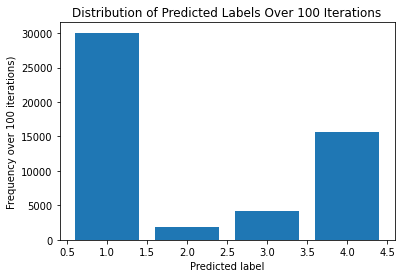

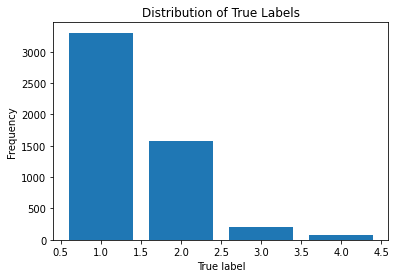

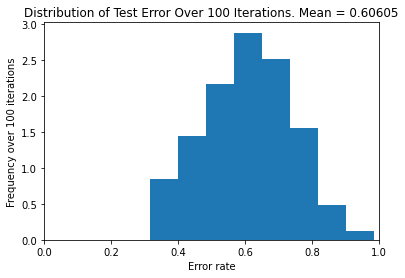

In [695]:
avg_err, best_w_hat, min_err = perform_ls(N, "y_scale")

In [696]:
print("Average error rate over all iterations:", avg_err)

Average error rate over all iterations: 0.6060541586073501


In [697]:
print("Minimum error ever achieved:", min_err)

Minimum error ever achieved: 0.31721470019342357


In [698]:
best_w_hat 

array([[-4.14836049e+20],
       [ 4.64001102e+19],
       [ 2.68394370e+18],
       [ 4.74739494e+20],
       [-2.53815042e+18],
       [ 8.13366611e+18],
       [-5.01435608e+20],
       [-9.83419516e+18],
       [ 7.61875637e+18],
       [ 4.49323624e+18],
       [-5.95040489e+16],
       [ 1.40668426e+18],
       [-2.10295119e+18],
       [-3.90270855e+18],
       [ 6.27562568e+18],
       [ 3.26636494e+18],
       [ 1.34696664e+18],
       [ 3.78320734e+18],
       [-4.58459464e+18],
       [ 4.24343967e+18],
       [ 2.10667209e+19],
       [-6.64273895e+18],
       [ 6.16679801e+17],
       [ 3.85015185e+18],
       [ 8.11399082e+18],
       [-6.08529375e+18],
       [ 5.51412260e+19],
       [-5.29014241e+19],
       [-8.15777819e+19],
       [-6.62830629e+01],
       [ 7.71453390e+04],
       [ 6.52731165e+04],
       [ 6.29911567e+04],
       [ 6.26284597e+04],
       [ 7.30671930e+04],
       [ 5.29014241e+19],
       [ 8.38791213e+19],
       [ 6.53477004e+03],
       [ 8.7

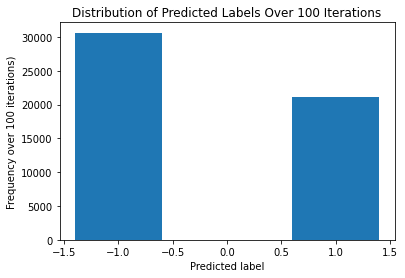

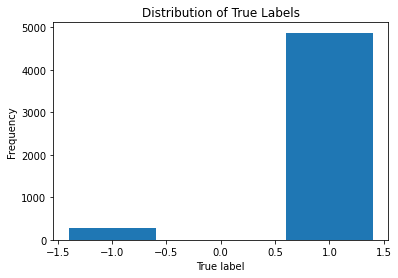

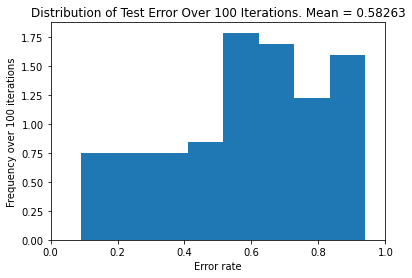

In [699]:
avg_err, best_w_hat, min_err = perform_ls(N, "y_binary")

In [700]:
print("Average error rate over all iterations:", avg_err)

Average error rate over all iterations: 0.5826305609284331


In [701]:
print("Minimum error ever achieved:", min_err)

Minimum error ever achieved: 0.09090909090909091


In [702]:
best_w_hat

array([[ 3.52508741e+02],
       [-4.20852827e+01],
       [ 3.13932718e+01],
       [-3.57703471e+02],
       [ 2.32248442e+00],
       [-1.76372108e+00],
       [ 1.12093623e+02],
       [ 7.64657054e-01],
       [-4.78974781e+00],
       [ 1.08640675e+01],
       [ 8.30359921e+00],
       [-7.41730844e+00],
       [ 6.48185991e-01],
       [ 5.43495695e+00],
       [-2.33360751e+00],
       [ 2.62166979e+01],
       [-6.57853273e+00],
       [-7.15464362e+00],
       [-1.09979929e+01],
       [ 6.48822335e+00],
       [ 3.42685480e+00],
       [-4.12624980e+00],
       [ 2.27254979e+00],
       [-8.98036989e+00],
       [-1.07794079e+00],
       [-1.11595288e-01],
       [-5.57597511e+00],
       [-5.53899687e+15],
       [ 9.46106464e+13],
       [ 2.95427461e-01],
       [-2.11153585e+00],
       [-2.07175990e+00],
       [-2.12452651e+00],
       [-2.14648854e+00],
       [-2.17809805e+00],
       [ 5.53899687e+15],
       [-9.46106464e+13],
       [ 5.77705386e+00],
       [ 5.1